# Genrative Adversarial Network

In [2]:
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow.keras.metrics as metrics
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus: tf.config.experimental.set_memory_growth(gpus[0], True)

import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

In [5]:
latent_size = 64
hidden_size = 256
image_size = 784
num_epochs = 200
batch_size = 100

In [6]:
train_data, test_data = tf.keras.datasets.mnist.load_data()

N = train_data[0].shape[0]
N

60000

In [7]:
train_dataset = tf.data.Dataset.from_tensor_slices((
    train_data[0].reshape(-1, 28, 28, 1).astype(np.float32) / 255, 
    train_data[1].astype(np.int32)
)).batch(batch_size).shuffle(10000)

train_dataset

<ShuffleDataset shapes: ((None, 28, 28, 1), (None,)), types: (tf.float32, tf.int32)>

### Discriminator
Discriminator $D(x, \phi)$ Input data $x$가 진짜 이미지 또는 가짜 이미지를 분별 역할을한다. 이것은 2 클래스 분류를 위해 Sigmoid function을 output activation function에 이용하고있다.

In [8]:
D = tf.keras.Sequential([
    L.InputLayer([28, 28, 1]),
    L.Flatten(),
    L.Dense(hidden_size, activation=tf.nn.leaky_relu),
    L.Dense(hidden_size, activation=tf.nn.leaky_relu),
    L.Dense(1, activation=tf.nn.sigmoid),
])

D.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               200960    
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 267,009
Trainable params: 267,009
Non-trainable params: 0
_________________________________________________________________


### Generator
Generator $G(z, \theta)$ 
난수 $ z $를 입력하면 적절한 이미지를 출력한다. 다음 코드에서는 $ 28 x 28 $ 픽셀의 이미지를 돌려 준다. $ G (z \ theta) $가 생성 한 이미지가 GAN에서는 '가짜 사진'라는 취급이다. 출력의 활성화 함수는 $ \ rm tanh (\ cdot) $이다. 이미지로 출력하는 경우 아래의 거리, $ (0, 1) $되도록 치역을 조작한다.

In [10]:
G = tf.keras.Sequential([
    L.InputLayer([latent_size]),
    L.Dense(hidden_size, activation=tf.nn.relu),
    L.Dense(hidden_size, activation=tf.nn.relu),
    L.Dense(784, activation=tf.nn.tanh),
    L.Reshape([28, 28, 1])
])

G.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 256)               16640     
_________________________________________________________________
dense_4 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_5 (Dense)              (None, 784)               201488    
_________________________________________________________________
reshape (Reshape)            (None, 28, 28, 1)         0         
Total params: 283,920
Trainable params: 283,920
Non-trainable params: 0
_________________________________________________________________


## Loss function
Loss function은 Binary_cross_entropy를 이용한다. GAN의 원래의 문제 설정은 다음이다. 𝐷 이미지가 가짜인지 진짜인지 알 2 클래스 분류에 강해지는 방법을 터득하는 한편, 𝐺는 𝐷이 분류에 실수 있도록 (즉 진짜 가까운 이미지를 만들어 낼 수 있도록) 학습 의도가있다.

$$
\begin{align}
G^\ast&={\rm arg}\min_G \max_D V(G,D) \\
V(G,D)&=\mathbb{E}_{x\sim p_t(x)} \left[ \log D(x) \right] + \mathbb{E}_{{\bf z}\sim p_{\bf z}({\bf z})} \left[ \log\left( 1-D\left( G({\bf z}) \right) \right) \right]
\end{align}
$$


`denorm` 함수는 이미지를 $ (0, 1) $로 변경하기위한 처리이다.

In [11]:
def loss_fn(y, y_pre):
    return tf.reduce_sum(metrics.binary_crossentropy(y, y_pre))

optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4)

def denorm(x):
    out = (x + 1) / 2
    return tf.clip_by_value(x, 0, 1)


### Discriminator 업데이트
$ D (x, \ phi) $ 매개 변수 $ \ phi $를 업데이트하려면 $ G (z \ theta) $ 분들은 고정 된 것을 이용한다. 구체적으로는 다음과 같은 흐름이다.

1 : 가짜 이미지
$
x ^ {*} = G (z \ theta)
$
를 생성한다.

2 : 진짜 이미지 $ x $를 준비한다.

3 : 가짜 $ x ^ {*} $에 대한 $ D $ 예상
$
y ^ {*} = D (x ^ {*}, \ phi)
$
를 계산한다.

4 : 진짜 $ x $에 대한 $ D $ 예상
$
y = D (x, \ phi)
$
를 계산한다.

5 : 아래의 손실 함수를 계산 ($ \ sum $ 미니 일괄 데이터에의 합).

$$
\ sum [\ log (y) - \ log (1 - y ^ {*})]
$$

6 : $ D (x, \ phi) $ 매개 변수 $ \ phi $에 대해서만 기울기를 계산 매개 변수를 업데이트한다.

위의 흐름을 실현하는 코드는 아래와된다.
`with tf.GradientTape () as g`의 맥락에서`g.watch (D.variables)`라고하면`D`가 포함 된 매개 변수 만 기울기 계산을 위해 계산기 그래프를 준비 있는 것에주의 (따로 이렇게하지 않고 모든 기울기를 구할 준비를 해 둡니다하면서 매개 변수를 갱신 할 때`D.variables` 만 업데이트하는 식으로 할 수 있지만, 불필요한 계산 은 생략에 넘었던 적은 없다.

In [13]:
@tf.function
def D_train(images):
    real_labels = tf.ones([batch_size, 1])
    fake_labels = tf.zeros([batch_size, 1])    

    # Compute BCE_Loss using real images where BCE_Loss(x, y): 
    #         - y * log(D(x)) - (1-y) * log(1 - D(x))
    # Second term of the loss is always zero since real_labels == 1
    
    with tf.GradientTape() as g:
        g.watch(D.variables)
        outputs = D(images)
        d_loss_real = loss_fn(real_labels, outputs)
    
        # Compute BCELoss using fake images
        # First term of the loss is always zero since fake_labels == 0
        z = tf.random.normal([batch_size, latent_size])
        fake_images = G(z)
        outputs = D(fake_images)
        d_loss_fake = loss_fn(fake_labels, outputs)
        
        # Backprop and optimize
        d_loss = d_loss_real + d_loss_fake
    
    grads = g.gradient(d_loss, D.variables)
    optimizer.apply_gradients(zip(grads, D.variables))
    
    return d_loss


### Generator 업데이트
여기에서 $ D (x, \ phi) $를 고정한다.

1. $ z ^ {*} \ sim \ mathcal N (0, 1) $로 난수 생성

2. 가짜 이미지 $ x ^ {*} = G (z ^ {*}, \ theta) $를 생성합니다.

3. 가짜에 대한 예상 $ y ^ {*} = D (x ^ * \ phi) $를 얻는다.

4. 아래의 손실 함수를 계산

$$
\ sum [\ log (1-y ^ {*})]
$$

5. $ G (z \ theta) $ 매개 변수 $ \ theta $ 관해서 경사를 계산하고 업데이트를 실시한다.

In [15]:
@tf.function
def G_train():
    real_labels = tf.ones([batch_size, 1])
    # Compute loss with fake images
    z = tf.random.normal([batch_size, latent_size])
    
    with tf.GradientTape() as g:
        g.watch(G.variables)
        fake_images = G(z)
        outputs = D(fake_images)

        # https://arxiv.org/pdf/1406.2661.pdf
        g_loss = loss_fn(real_labels, outputs)

    # Backprop and optimize
    grads = g.gradient(g_loss, G.variables)
    optimizer.apply_gradients(zip(grads, G.variables))    

    return g_loss

In [16]:
# Start training
total_step = N // batch_size
for epoch in range(num_epochs):
    for i, (images, _) in enumerate(train_dataset):

        with tf.device("/gpu:0"):

            d_loss = D_train(images)

            g_loss = G_train()
        
        if (i+1) % 200 == 0:
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}' 
                  .format(epoch, num_epochs, i+1, total_step, 
                          d_loss.numpy(), g_loss.numpy()))

Epoch [0/200], Step [200/600], d_loss: 8.7168, g_loss: 651.3174
Epoch [0/200], Step [400/600], d_loss: 17.3821, g_loss: 1071.7988
Epoch [0/200], Step [600/600], d_loss: 5.5692, g_loss: 771.5803
Epoch [1/200], Step [200/600], d_loss: 25.9263, g_loss: 523.5656
Epoch [1/200], Step [400/600], d_loss: 107.7911, g_loss: 145.1076
Epoch [1/200], Step [600/600], d_loss: 62.0404, g_loss: 322.0201
Epoch [2/200], Step [200/600], d_loss: 26.9483, g_loss: 302.3680
Epoch [2/200], Step [400/600], d_loss: 5.0823, g_loss: 496.7716
Epoch [2/200], Step [600/600], d_loss: 11.8052, g_loss: 541.9732
Epoch [3/200], Step [200/600], d_loss: 4.3007, g_loss: 765.4202
Epoch [3/200], Step [400/600], d_loss: 6.4619, g_loss: 676.5262
Epoch [3/200], Step [600/600], d_loss: 9.7756, g_loss: 596.9442
Epoch [4/200], Step [200/600], d_loss: 10.8395, g_loss: 643.7305
Epoch [4/200], Step [400/600], d_loss: 13.1995, g_loss: 458.9022
Epoch [4/200], Step [600/600], d_loss: 10.7297, g_loss: 462.3365
Epoch [5/200], Step [200/600]

Epoch [42/200], Step [200/600], d_loss: 20.9288, g_loss: 625.3329
Epoch [42/200], Step [400/600], d_loss: 9.1940, g_loss: 620.6431
Epoch [42/200], Step [600/600], d_loss: 19.3520, g_loss: 607.6923
Epoch [43/200], Step [200/600], d_loss: 12.9042, g_loss: 566.6420
Epoch [43/200], Step [400/600], d_loss: 9.2725, g_loss: 713.9199
Epoch [43/200], Step [600/600], d_loss: 17.6354, g_loss: 742.6047
Epoch [44/200], Step [200/600], d_loss: 13.8715, g_loss: 573.5837
Epoch [44/200], Step [400/600], d_loss: 19.9352, g_loss: 650.0098
Epoch [44/200], Step [600/600], d_loss: 8.8325, g_loss: 671.9416
Epoch [45/200], Step [200/600], d_loss: 17.1203, g_loss: 921.6164
Epoch [45/200], Step [400/600], d_loss: 22.1834, g_loss: 580.5855
Epoch [45/200], Step [600/600], d_loss: 15.3177, g_loss: 676.0052
Epoch [46/200], Step [200/600], d_loss: 15.7626, g_loss: 693.2455
Epoch [46/200], Step [400/600], d_loss: 12.5452, g_loss: 756.2570
Epoch [46/200], Step [600/600], d_loss: 9.9717, g_loss: 563.4818
Epoch [47/200]

Epoch [83/200], Step [600/600], d_loss: 20.3552, g_loss: 534.5345
Epoch [84/200], Step [200/600], d_loss: 22.0134, g_loss: 435.1993
Epoch [84/200], Step [400/600], d_loss: 29.1425, g_loss: 424.2267
Epoch [84/200], Step [600/600], d_loss: 26.6611, g_loss: 485.1700
Epoch [85/200], Step [200/600], d_loss: 26.4366, g_loss: 407.1342
Epoch [85/200], Step [400/600], d_loss: 29.7113, g_loss: 506.5379
Epoch [85/200], Step [600/600], d_loss: 27.7559, g_loss: 514.8327
Epoch [86/200], Step [200/600], d_loss: 44.4312, g_loss: 485.0998
Epoch [86/200], Step [400/600], d_loss: 19.3674, g_loss: 552.4430
Epoch [86/200], Step [600/600], d_loss: 21.1646, g_loss: 461.5353
Epoch [87/200], Step [200/600], d_loss: 22.1528, g_loss: 355.6635
Epoch [87/200], Step [400/600], d_loss: 32.3658, g_loss: 491.1140
Epoch [87/200], Step [600/600], d_loss: 34.5604, g_loss: 493.3291
Epoch [88/200], Step [200/600], d_loss: 19.6451, g_loss: 466.1782
Epoch [88/200], Step [400/600], d_loss: 21.2584, g_loss: 391.0885
Epoch [88/

Epoch [125/200], Step [200/600], d_loss: 71.9132, g_loss: 341.5539
Epoch [125/200], Step [400/600], d_loss: 45.6858, g_loss: 336.3877
Epoch [125/200], Step [600/600], d_loss: 42.5122, g_loss: 354.0045
Epoch [126/200], Step [200/600], d_loss: 47.8709, g_loss: 354.8654
Epoch [126/200], Step [400/600], d_loss: 36.1554, g_loss: 416.0168
Epoch [126/200], Step [600/600], d_loss: 39.6733, g_loss: 348.4929
Epoch [127/200], Step [200/600], d_loss: 21.8960, g_loss: 402.2571
Epoch [127/200], Step [400/600], d_loss: 37.2155, g_loss: 435.7347
Epoch [127/200], Step [600/600], d_loss: 41.1545, g_loss: 324.0194
Epoch [128/200], Step [200/600], d_loss: 38.8110, g_loss: 356.8338
Epoch [128/200], Step [400/600], d_loss: 53.8825, g_loss: 348.4719
Epoch [128/200], Step [600/600], d_loss: 42.4421, g_loss: 289.6659
Epoch [129/200], Step [200/600], d_loss: 41.1444, g_loss: 366.4784
Epoch [129/200], Step [400/600], d_loss: 60.6735, g_loss: 353.1062
Epoch [129/200], Step [600/600], d_loss: 30.1645, g_loss: 332.

Epoch [166/200], Step [200/600], d_loss: 73.6751, g_loss: 355.1936
Epoch [166/200], Step [400/600], d_loss: 57.7140, g_loss: 295.2104
Epoch [166/200], Step [600/600], d_loss: 59.7344, g_loss: 334.1310
Epoch [167/200], Step [200/600], d_loss: 45.0669, g_loss: 334.7548
Epoch [167/200], Step [400/600], d_loss: 41.3368, g_loss: 286.8493
Epoch [167/200], Step [600/600], d_loss: 47.1815, g_loss: 295.4720
Epoch [168/200], Step [200/600], d_loss: 51.2154, g_loss: 273.3553
Epoch [168/200], Step [400/600], d_loss: 38.6740, g_loss: 319.6619
Epoch [168/200], Step [600/600], d_loss: 51.3416, g_loss: 304.1992
Epoch [169/200], Step [200/600], d_loss: 48.2031, g_loss: 369.7209
Epoch [169/200], Step [400/600], d_loss: 65.3028, g_loss: 314.9152
Epoch [169/200], Step [600/600], d_loss: 61.6670, g_loss: 304.9638
Epoch [170/200], Step [200/600], d_loss: 35.1791, g_loss: 323.2278
Epoch [170/200], Step [400/600], d_loss: 48.3114, g_loss: 292.3427
Epoch [170/200], Step [600/600], d_loss: 59.4019, g_loss: 290.

In [17]:
image_generated = denorm(G(tf.random.normal([10, latent_size])))

In [18]:
image_generated_numpy = image_generated.numpy().reshape(-1, 28, 28)

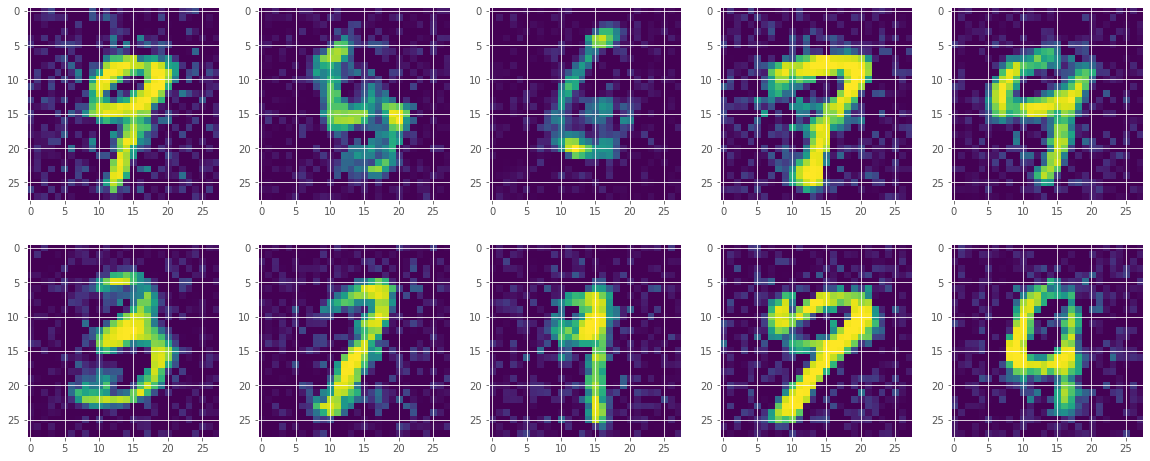

In [19]:
plt.figure(figsize=(20, 8))
for i, img_show in enumerate(image_generated_numpy):
    plt.subplot(2, 5, i+1)
    plt.imshow(img_show)